# Import Library

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import base64
from io import BytesIO

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import BallTree
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.spatial import KDTree

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
pd.reset_option('display.max_rows', None)
pd.reset_option('display.max_columns', None)
pd.reset_option('display.max_colwidth', None)

# Preprocessing 

## Import Data

In [3]:
raw_clust_df  = pd.read_csv('./clustering_dataset/raw_cluster.csv')
raw_dki_df    = pd.read_csv('./clustering_dataset/raw_dki_cluster.csv') 
raw_banten_df = pd.read_csv('./clustering_dataset/raw_banten_cluster.csv') 
raw_jabar_df  = pd.read_csv('./clustering_dataset/raw_jabar_cluster.csv') 
raw_jateng_df = pd.read_csv('./clustering_dataset/raw_jateng_cluster.csv') 
raw_jatim_df  = pd.read_csv('./clustering_dataset/raw_jatim_cluster.csv') 
raw_diy_df    = pd.read_csv('./clustering_dataset/raw_diy_cluster.csv') 

In [4]:
selected_col_clust = ['place_id', 'name', 'reviews', 'most_popular_times', 'main_category',
                      'rating','reviews_per_rating', 'coordinates'
                     ]

clust_df        = raw_clust_df[selected_col_clust]
clust_df_dki    = raw_dki_df[selected_col_clust]
clust_df_banten = raw_banten_df[selected_col_clust]
clust_df_jabar  = raw_jabar_df[selected_col_clust]
clust_df_jateng = raw_jateng_df[selected_col_clust]
clust_df_jatim  = raw_dki_df[selected_col_clust]
clust_df_diy    = raw_dki_df[selected_col_clust]

In [5]:
clust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30189 entries, 0 to 30188
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   place_id            30189 non-null  object 
 1   name                30179 non-null  object 
 2   reviews             30189 non-null  int64  
 3   most_popular_times  30189 non-null  object 
 4   main_category       30173 non-null  object 
 5   rating              30189 non-null  float64
 6   reviews_per_rating  30189 non-null  object 
 7   coordinates         30189 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.8+ MB


## Convert Json 

### reviews_per_rating

In [6]:
# Ubah string JSON menjadi dictionary
clust_df['reviews_per_rating'] = clust_df['reviews_per_rating'].apply(lambda x: json.loads(x.replace('null', '0')))

In [7]:

# Pisahkan nilai dari dictionary ke kolom baru
clust_df['reviews_one_star'] = clust_df['reviews_per_rating'].apply(lambda x: x.get('1', 0))
clust_df['reviews_two_star'] = clust_df['reviews_per_rating'].apply(lambda x: x.get('2', 0))
clust_df['reviews_three_star'] = clust_df['reviews_per_rating'].apply(lambda x: x.get('3', 0))
clust_df['reviews_four_star'] = clust_df['reviews_per_rating'].apply(lambda x: x.get('4', 0))
clust_df['reviews_five_star'] = clust_df['reviews_per_rating'].apply(lambda x: x.get('5', 0))

In [8]:
clust_df.drop(columns=['reviews_per_rating'], inplace=True)

In [9]:
clust_df.head(3)

,place_id,name,reviews,most_popular_times,main_category,rating,coordinates,reviews_one_star,reviews_two_star,reviews_three_star,reviews_four_star,reviews_five_star
0,ChIJd0EvQ4_zaS4ROHLtujX-hmE,Bebek Kaleyo Tebet,11016,"[{""hour_of_day"": 19, ""average_popularity"": 80....",Restoran Indonesia,4.50,"{""latitude"": -6.2258, ""longitude"": 106.8568683}",184,152,791,2528,7361
1,ChIJEwwrrXH3aS4RcBo0XDRfOnc,McDonald's Puri Kembangan,9072,"[{""hour_of_day"": 23, ""average_popularity"": 88....",Restoran Cepat Saji,4.60,"{""latitude"": -6.187604599999999, ""longitude"": ...",204,117,490,1760,6501
2,ChIJC_lABffzaS4RZGzb2lD-iAw,Setiabudi One,8456,"[{""hour_of_day"": 18, ""average_popularity"": 84....",Pujasera,4.60,"{""latitude"": -6.2152515, ""longitude"": 106.8299...",61,48,529,1996,5822


### Main_Category Cardinality

In [10]:
# Membaca dictionary pengelompokan dari file .txt
with open('category_groups.txt', 'r', encoding='utf-8') as file:
    category_groups = json.load(file)

# Fungsi untuk mengelompokkan kategori
def categorize(category):
    for group, categories in category_groups.items():
        if category in categories:
            return group
    return "Lainnya"

# Membuat kolom baru 'main_category_group' di DataFrame
clust_df['main_category'] = clust_df['main_category'].apply(categorize)

### coordinates

In [11]:
# Fungsi untuk mengekstrak latitude dan longitude
def extract_latitude(coord):
    return coord['latitude']

def extract_longitude(coord):
    return coord['longitude']

# Mengubah string JSON menjadi dictionary
clust_df['coordinates'] = clust_df['coordinates'].apply(json.loads)

# Membuat kolom baru untuk latitude dan longitude
clust_df['latitude'] = clust_df['coordinates'].apply(extract_latitude)
clust_df['longitude'] = clust_df['coordinates'].apply(extract_longitude)

# Menghapus kolom coordinates asli
clust_df = clust_df.drop(columns=['coordinates'])

In [12]:
# Filter data berdasarkan koordinat untuk memilih hanya data di dalam batas wilayah Indonesia
clust_df = clust_df[(clust_df['latitude'] >= -11.00) & (clust_df['latitude'] <= 6.00) & 
                      (clust_df['longitude'] >= 95.00) & (clust_df['longitude'] <= 141.00)]

In [13]:
clust_df.head(3)

,place_id,name,reviews,most_popular_times,main_category,rating,reviews_one_star,reviews_two_star,reviews_three_star,reviews_four_star,reviews_five_star,latitude,longitude
0,ChIJd0EvQ4_zaS4ROHLtujX-hmE,Bebek Kaleyo Tebet,11016,"[{""hour_of_day"": 19, ""average_popularity"": 80....",Restoran,4.50,184,152,791,2528,7361,-6.23,106.86
1,ChIJEwwrrXH3aS4RcBo0XDRfOnc,McDonald's Puri Kembangan,9072,"[{""hour_of_day"": 23, ""average_popularity"": 88....",Restoran,4.60,204,117,490,1760,6501,-6.19,106.74
2,ChIJC_lABffzaS4RZGzb2lD-iAw,Setiabudi One,8456,"[{""hour_of_day"": 18, ""average_popularity"": 84....",Restoran,4.60,61,48,529,1996,5822,-6.22,106.83


### Most Popular Times

In [14]:
# Fungsi untuk mendapatkan rata-rata, standar deviasi, dan waktu rata-rata dari baris most_popular_times
def extract_features(row):
    if row == 'Not Present':
        return pd.Series(['Not Present', 'Not Present', 'Not Present'])
    
    data = json.loads(row)
    hour_list = [item['hour_of_day'] for item in data]
    popularity_list = [item['average_popularity'] for item in data]

    average_hour = np.mean(hour_list)
    std_hour = np.std(hour_list)
    avg_popularity = np.mean(popularity_list)

    return pd.Series([average_hour, std_hour, avg_popularity])

# Membuat kolom baru berdasarkan most_popular_times
new_cols = clust_df['most_popular_times'].apply(extract_features)
new_cols.columns = ['average_hour', 'std_hour', 'avg_popularity']

# Menggabungkan kolom baru dengan DataFrame awal
clust_df = pd.concat([clust_df, new_cols], axis=1)

In [15]:
# Fungsi untuk mendapatkan nilai top_hour_popularity dan top_average_popularity
def extract_top_values(row):
    if row == 'Not Present':
        return pd.Series(['Not Present', 'Not Present'])
    
    data = json.loads(row)
    max_popularity_item = max(data, key=lambda x: x['average_popularity'])
    top_hour_popularity = max_popularity_item['hour_of_day']
    top_average_popularity = max_popularity_item['average_popularity']
    
    return pd.Series([top_hour_popularity, top_average_popularity])

# Membuat kolom baru untuk top_hour_popularity dan top_average_popularity
top_values_cols = clust_df['most_popular_times'].apply(extract_top_values)
top_values_cols.columns = ['top_hour_popularity', 'top_average_popularity']

# Menggabungkan kolom baru dengan DataFrame awal
clust_df = pd.concat([clust_df, top_values_cols], axis=1)

clust_df = clust_df.drop(columns=['most_popular_times'])

## Nearest Competitor

In [16]:
# Konversi latitude dan longitude menjadi radian untuk meningkatkan akurasi pada perhitungan jarak geodesik
coords = np.deg2rad(clust_df[['latitude', 'longitude']].values)

# Buat KDTree dari koordinat
tree = KDTree(coords)

# Cari 3 tetangga terdekat untuk setiap baris (termasuk dirinya sendiri)
distances, indices = tree.query(coords, k=3)

# Memastikan kompetitor tidak sama dengan baris itu sendiri
nearest_indices = []
nearest_distances = []

for i in range(len(clust_df)):
    for j in range(1, 3):  # Mulai dari 1 untuk menghindari dirinya sendiri
        if clust_df['place_id'].iloc[i] != clust_df['place_id'].iloc[indices[i, j]]:
            nearest_indices.append(indices[i, j])
            nearest_distances.append(distances[i, j] * 6371000)  # Konversi dari radian ke meter
            break

# Mengambil data kompetitor terdekat dari clust_df menggunakan nearest_indices
competitor_names = clust_df['name'].values[nearest_indices]
competitor_place_ids = clust_df['place_id'].values[nearest_indices]
competitor_coordinates = clust_df[['latitude', 'longitude']].values[nearest_indices]
competitor_ratings = clust_df['rating'].values[nearest_indices]

# Menambahkan kolom informasi kompetitor terdekat ke DataFrame asli
#clust_df['competitor_name'] = competitor_names
clust_df['competitor_place_id'] = competitor_place_ids
#clust_df['competitor_coordinates'] = [f"({lat}, {lon})" for lat, lon in competitor_coordinates]
clust_df['competitor_distance_m'] = nearest_distances
clust_df['competitor_rating'] = competitor_ratings

## Imputasi Not Present menggunakan KNNImputer

In [17]:
# Mengganti 'not present' dengan NaN
clust_df.replace('Not Present', np.nan, inplace=True)

# Mengubah kolom yang bersangkutan menjadi tipe data float
cols_to_impute = ['average_hour', 'std_hour', 'avg_popularity', 'top_hour_popularity', 'top_average_popularity']
clust_df[cols_to_impute] = clust_df[cols_to_impute].astype(float)

# Inisialisasi KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Menerapkan KNNImputer hanya pada kolom yang bersangkutan
clust_df[cols_to_impute] = imputer.fit_transform(clust_df[cols_to_impute])

In [18]:
clust_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30188 entries, 0 to 30188
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   place_id                30188 non-null  object 
 1   name                    30178 non-null  object 
 2   reviews                 30188 non-null  int64  
 3   main_category           30188 non-null  object 
 4   rating                  30188 non-null  float64
 5   reviews_one_star        30188 non-null  int64  
 6   reviews_two_star        30188 non-null  int64  
 7   reviews_three_star      30188 non-null  int64  
 8   reviews_four_star       30188 non-null  int64  
 9   reviews_five_star       30188 non-null  int64  
 10  latitude                30188 non-null  float64
 11  longitude               30188 non-null  float64
 12  average_hour            30188 non-null  float64
 13  std_hour                30188 non-null  float64
 14  avg_popularity          30188 non-null  flo

## List 30 Places

In [19]:
# Ambil 5 baris secara acak dari setiap DataFrame dengan random_state yang sama
random_state = 2024
sample_dki = clust_df_dki.sample(n=5, random_state=random_state)
sample_banten = clust_df_banten.sample(n=5, random_state=random_state)
sample_jabar = clust_df_jabar.sample(n=5, random_state=random_state)
sample_jateng = clust_df_jateng.sample(n=5, random_state=random_state)
sample_jatim = clust_df_jatim.sample(n=5, random_state=random_state)
sample_diy = clust_df_diy.sample(n=5, random_state=random_state)

# Gabungkan semua sample menjadi satu DataFrame
merged_df = pd.concat([sample_dki, sample_banten, sample_jabar, sample_jateng, sample_jatim, sample_diy], ignore_index=True)

# Reset index pada DataFrame hasil gabungan
cluster_list_df = merged_df[['place_id', 'coordinates']].reset_index(drop=True)


In [20]:
# Mengubah string JSON menjadi dictionary
cluster_list_df['coordinates'] = cluster_list_df['coordinates'].apply(json.loads)

# Membuat kolom baru untuk latitude dan longitude
cluster_list_df['latitude'] = cluster_list_df['coordinates'].apply(extract_latitude)
cluster_list_df['longitude'] = cluster_list_df['coordinates'].apply(extract_longitude)

# Menghapus kolom coordinates asli
cluster_list_df = cluster_list_df.drop(columns=['coordinates'])

In [21]:
cluster_list_df

,place_id,latitude,longitude
0,ChIJiRE7OObyaS4RjTZYXPztwIY,-6.27,106.89
1,ChIJp9nOcVzyaS4RFBq-6Vd5vMc,-6.27,106.86
2,ChIJcwc56vUfai4RFd4IJnJhBxA,-6.12,106.91
3,ChIJ1cOqT_ghai4RZ__PEbA8P4g,-6.12,106.92
4,ChIJ3bfJ8KOLaS4RpfqZZa5f2Os,-6.21,106.96
5,ChIJ_-k9qsKRQS4RByQ3-salAUw,-5.92,106.01
6,ChIJxSVVSLw7Qi4RsTtlTah1O_E,-6.39,106.02
7,ChIJ64CWxCP7aS4RXy-Z7MqwdAw,-6.25,106.70
8,ChIJm6QNZcKPQS4ReeERG1ss7lk,-6.02,106.06
9,ChIJD_4QLkb7aS4R0vLWTpVx_y0,-6.30,106.72


## Create 30 Dataframe

In [22]:
# Radius dalam kilometer
radius_km = 4

# Mengubah koordinat menjadi array numpy
coords_clust_df = np.deg2rad(clust_df[['latitude', 'longitude']].values)

# Membangun BallTree
tree = BallTree(coords_clust_df, metric='haversine')

# List untuk menyimpan DataFrame yang dihasilkan
dataframes = []

# Iterasi melalui setiap baris di cluster_list_df
for index, row in cluster_list_df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    coords_point = np.deg2rad([[lat, lon]])
    
    # Melakukan query untuk menemukan semua titik dalam radius 5 km
    indices = tree.query_radius(coords_point, r=radius_km / 6371.0)
    
    # Mengambil hasil query dari clust_df
    within_radius = clust_df.iloc[indices[0]].reset_index(drop=True)
    
    # Tambahkan DataFrame hasil filter ke dalam list
    dataframes.append(within_radius)

In [23]:
dataframes[14].sort_values('name')

,place_id,name,reviews,main_category,rating,reviews_one_star,reviews_two_star,reviews_three_star,reviews_four_star,reviews_five_star,latitude,longitude,average_hour,std_hour,avg_popularity,top_hour_popularity,top_average_popularity,competitor_place_id,competitor_distance_m,competitor_rating
102,ChIJ7zN-HMizaS4RvRgiIX7s1cw,Adelia Food,0,Restoran,0.00,0,0,0,0,0,-6.73,107.05,16.33,1.96,51.93,16.51,55.30,ChIJxdlV_razaS4RY4kLttp5vTc,38.04,4.70
11,ChIJxRv_FuSzaS4RZJDblXZvnwQ,Angkringan Teh Aci,4,Kafe dan Kedai Kopi,4.00,1,0,0,0,3,-6.73,107.04,17.00,0.82,46.19,18.00,50.00,ChIJXX94ZtazaS4RINFdO1s0q14,5.11,5.00
19,ChIJ3ZIySSGzaS4Rh9mgggiIZ6Q,BC SFF,0,Kafe dan Kedai Kopi,0.00,0,0,0,0,0,-6.73,107.04,10.00,3.74,26.57,5.00,31.29,ChIJaRdzl7qzaS4RVi5MrZv7E6s,39.95,4.40
73,ChIJl3pX5umzaS4R1sagW4hYeOY,Berkat Jaya foodcourt,12,Kafe dan Kedai Kopi,4.30,1,1,0,1,9,-6.72,107.03,21.67,1.25,54.48,23.00,75.00,ChIJ-7KX4umzaS4R2Y4fRDSBJP4,56.89,0.00
36,ChIJrStms2WzaS4RYV2dRhf0emg,Bi Ai,0,Lainnya,0.00,0,0,0,0,0,-6.73,107.04,16.33,1.96,51.93,16.51,55.30,ChIJ8bmXg7mzaS4RUgb6Y638PE8,74.97,4.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,ChIJC59JmfyzaS4RxgkUL0smuPI,Yume Minibar,2,Kafe dan Kedai Kopi,5.00,0,0,0,0,2,-6.72,107.03,17.33,3.40,26.62,14.00,30.57,ChIJdYEMnuqzaS4RTo3XKhMspUU,24.75,5.00
22,ChIJx0lz4quzaS4RcjGMKGw-mOQ,gomu cheese tea cipanas,0,Kafe dan Kedai Kopi,0.00,0,0,0,0,0,-6.73,107.04,16.33,1.96,51.93,16.51,55.30,ChIJgb16kmCzaS4RAAFDYXSNGe0,36.20,5.00
0,ChIJYf2CDbWzaS4R0g1Mie2I21w,warung abiel,4,Toko Makanan dan Minuman,5.00,0,0,0,0,4,-6.74,107.04,7.00,2.94,37.71,3.00,45.00,ChIJ928ARj-zaS4RsVNgbr4V4co,441.80,4.30
26,ChIJnZeVGoizaS4RkKN4XfvRU_U,warung saung legit,26,Kafe dan Kedai Kopi,4.60,1,0,2,2,21,-6.73,107.01,9.67,5.91,36.29,5.00,37.00,ChIJOWy4ZHqzaS4RWpR72BjpBgs,115.74,0.00


In [24]:
dataframes[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   place_id                455 non-null    object 
 1   name                    455 non-null    object 
 2   reviews                 455 non-null    int64  
 3   main_category           455 non-null    object 
 4   rating                  455 non-null    float64
 5   reviews_one_star        455 non-null    int64  
 6   reviews_two_star        455 non-null    int64  
 7   reviews_three_star      455 non-null    int64  
 8   reviews_four_star       455 non-null    int64  
 9   reviews_five_star       455 non-null    int64  
 10  latitude                455 non-null    float64
 11  longitude               455 non-null    float64
 12  average_hour            455 non-null    float64
 13  std_hour                455 non-null    float64
 14  avg_popularity          455 non-null    fl

# Exploratory Data Analysis

In [25]:
# Daftar kolom yang ingin dicek distribusinya
eda_cols = ['rating', 'reviews_one_star', 'reviews_two_star', 
            'reviews_three_star', 'reviews_four_star', 
            'reviews_five_star', 'average_hour', 'std_hour', 
            'avg_popularity', 'competitor_distance_m', 'competitor_rating'
            ]

# Indeks dataframes yang ingin ditampilkan
selected_indices = [0, 5, 10, 15, 20, 25]

### Cek distribusi setiap variabel numerik

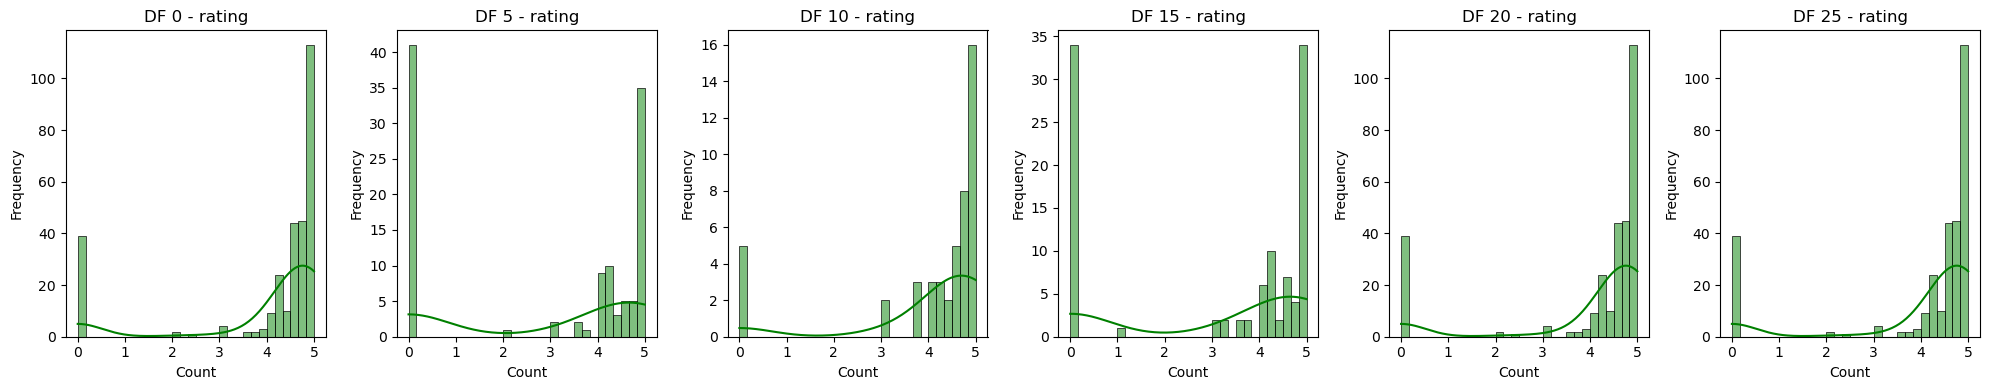

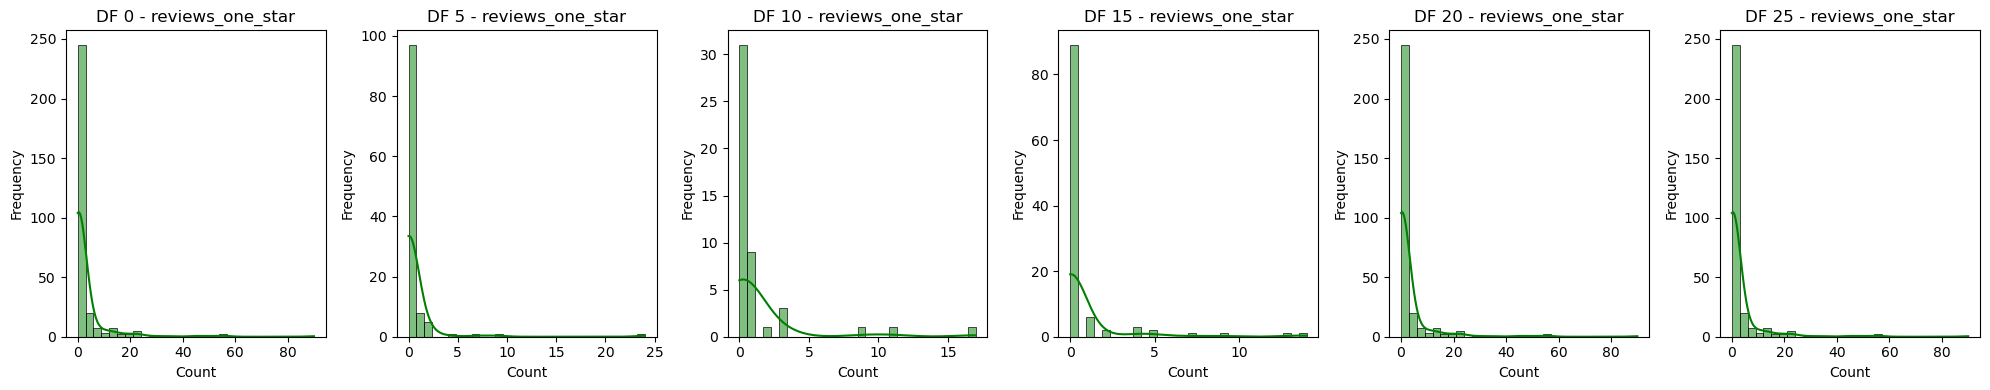

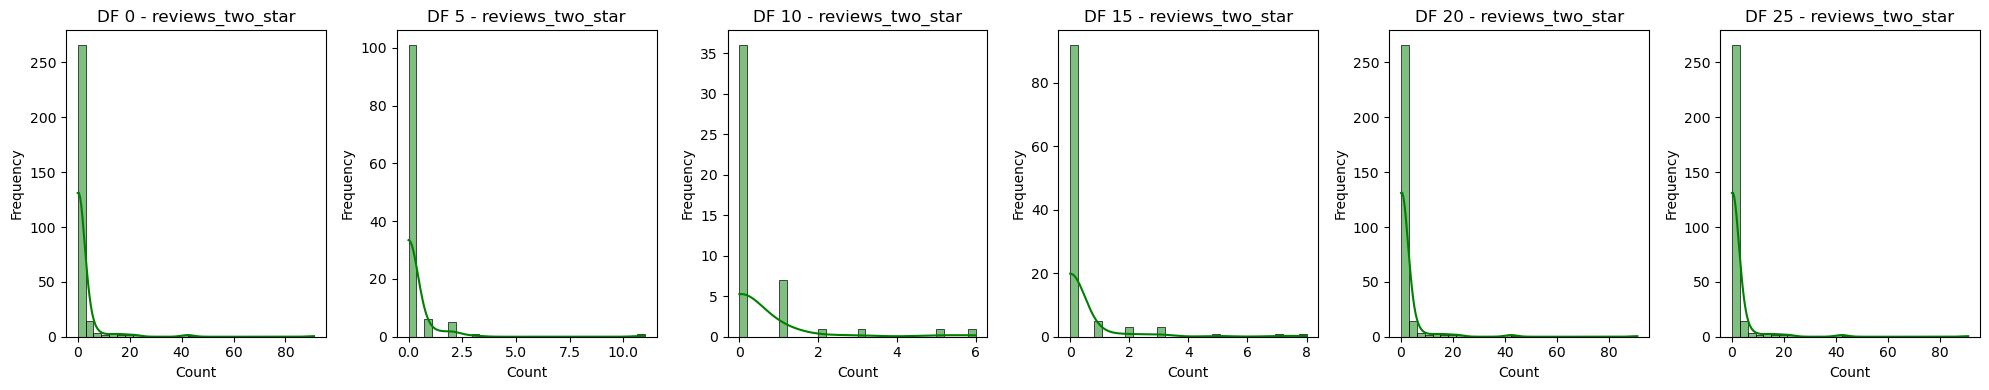

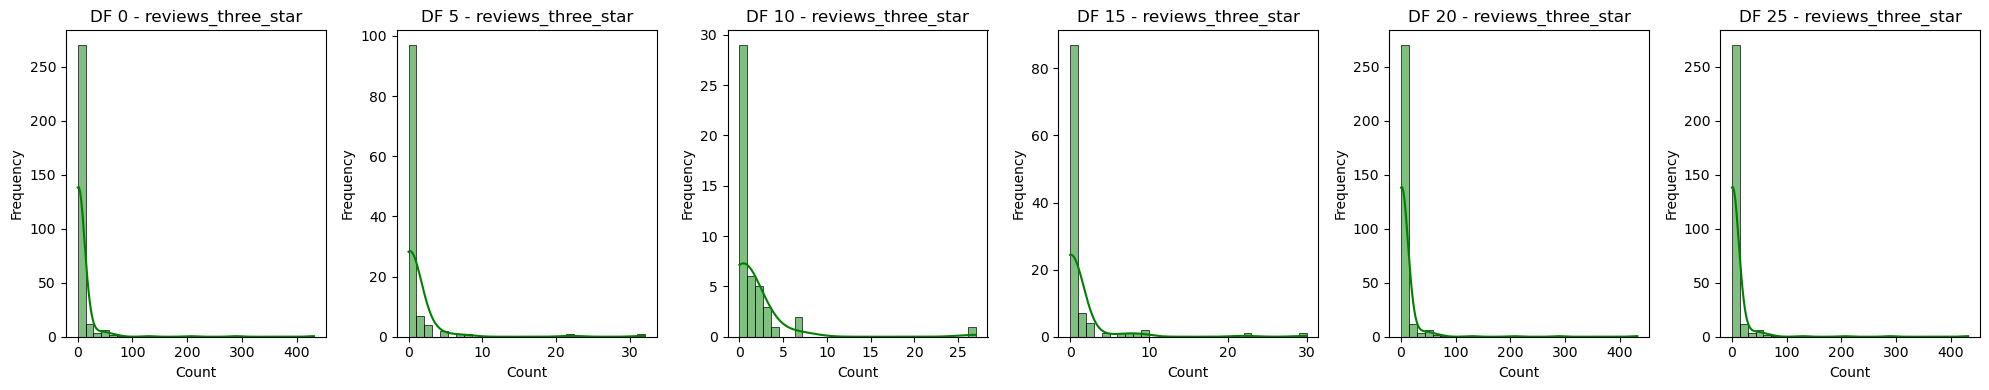

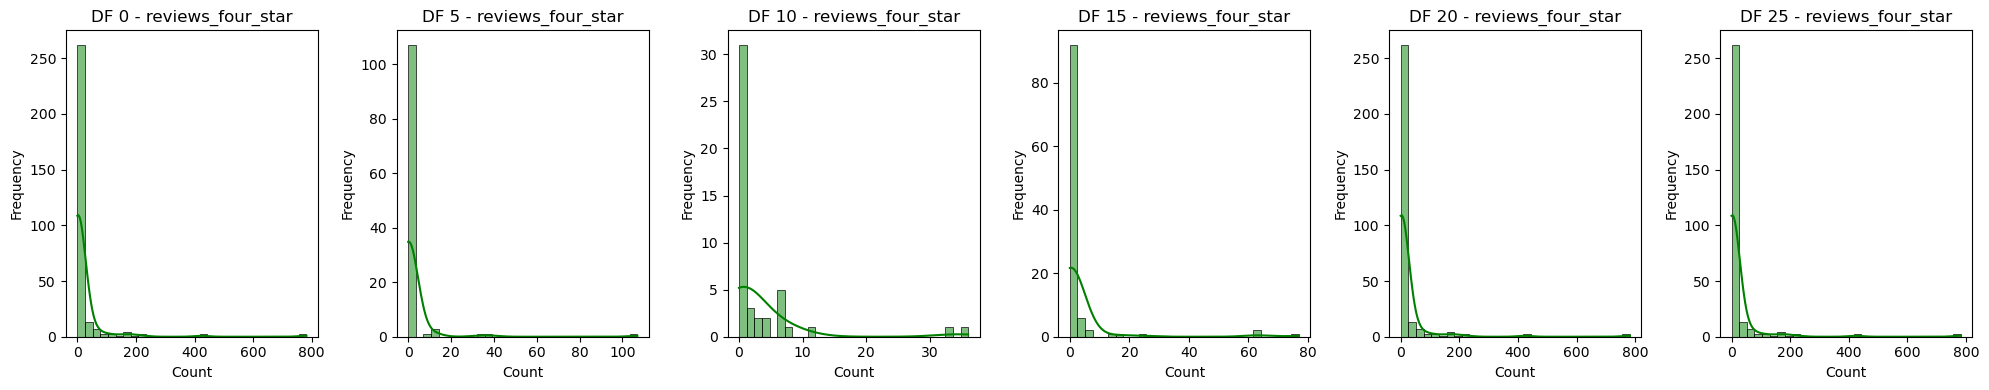

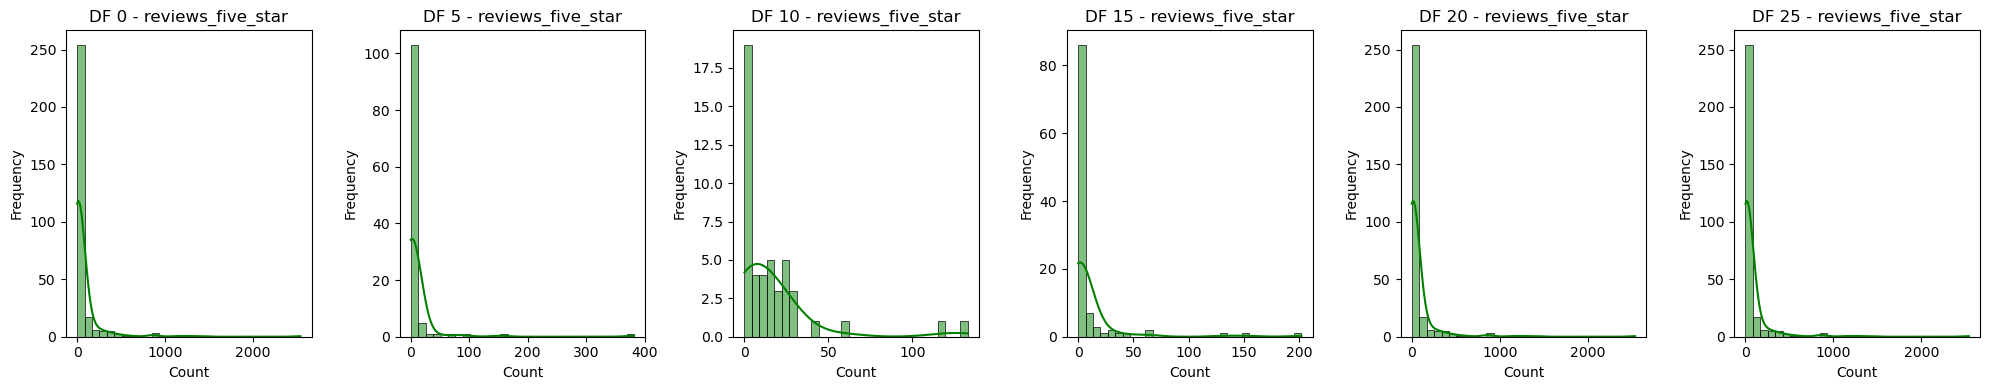

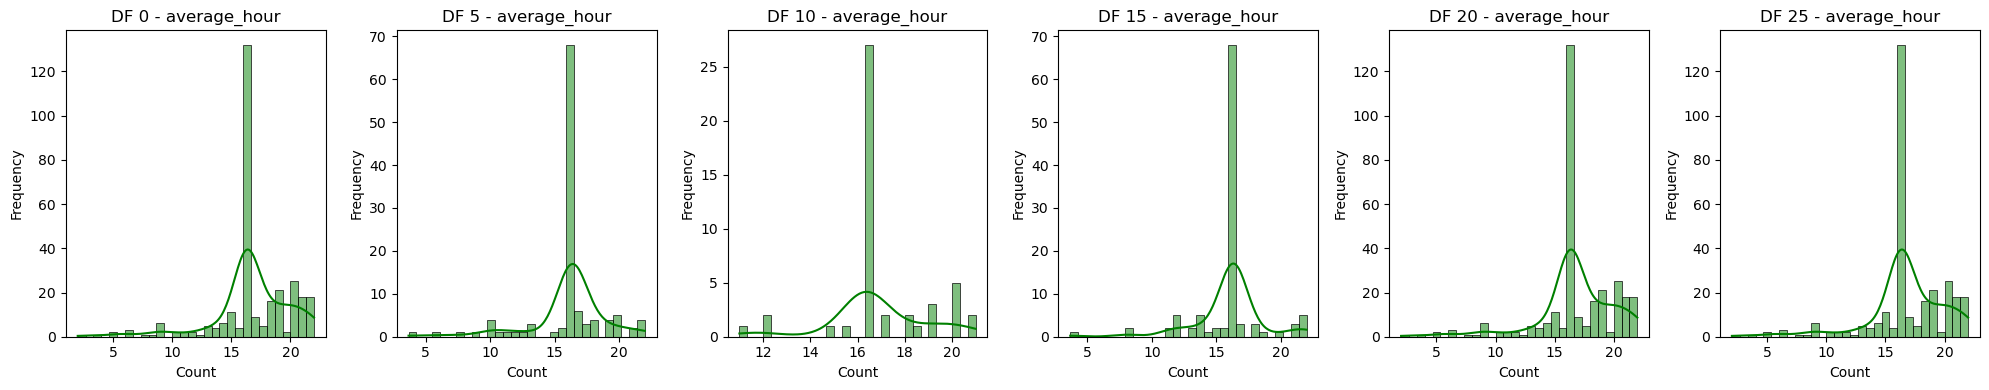

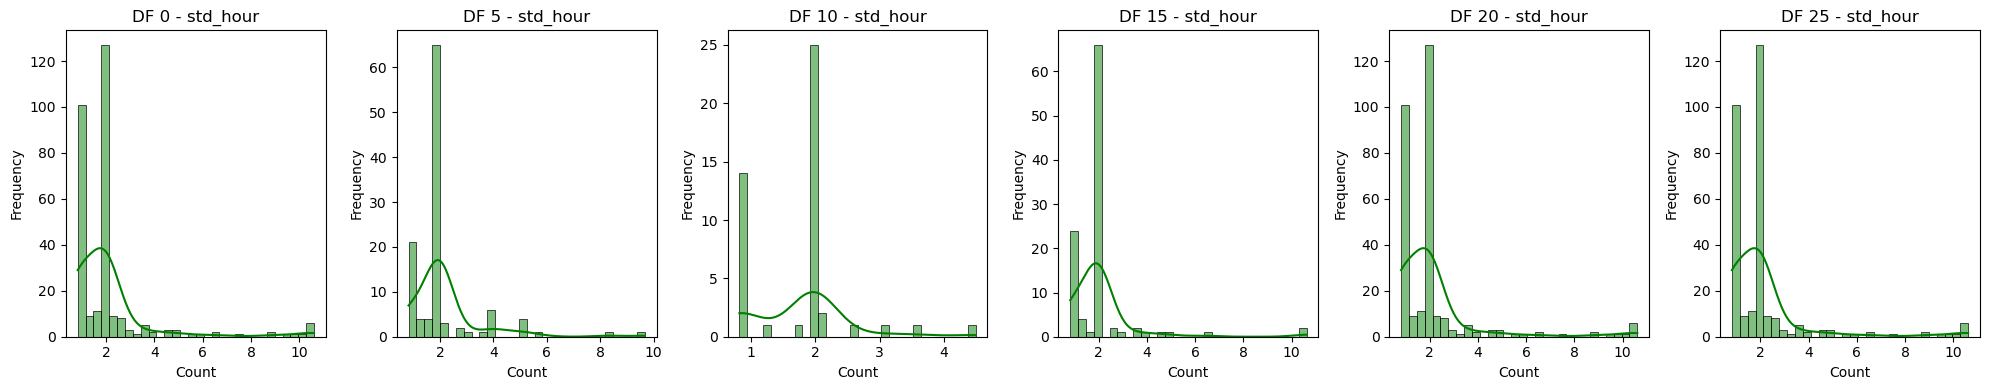

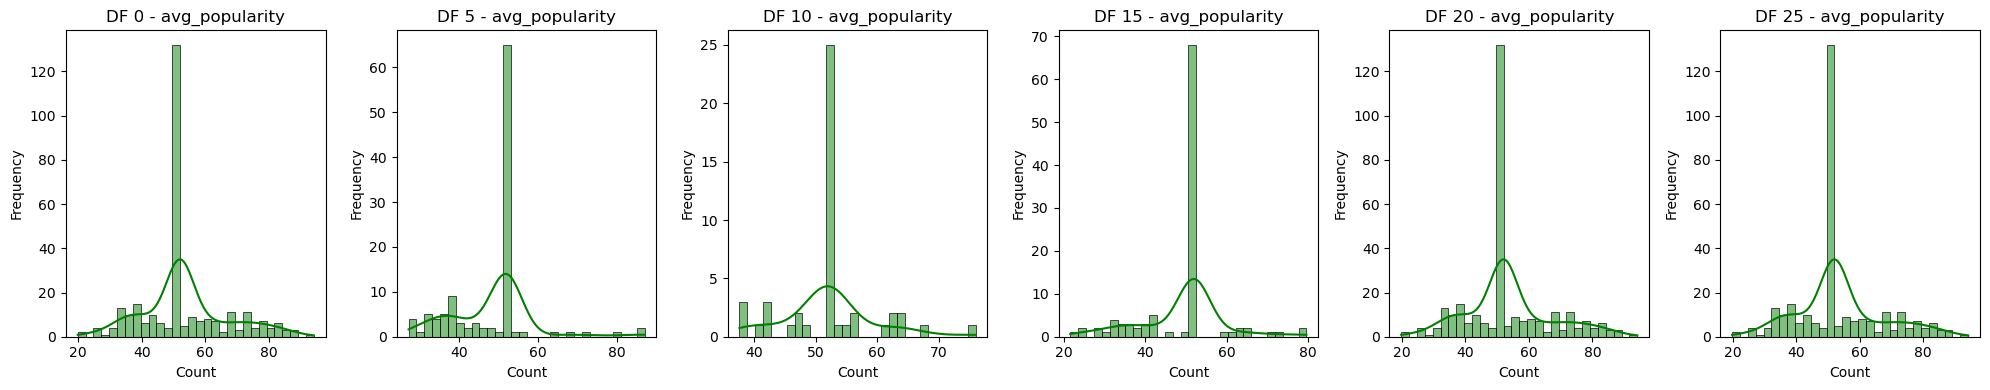

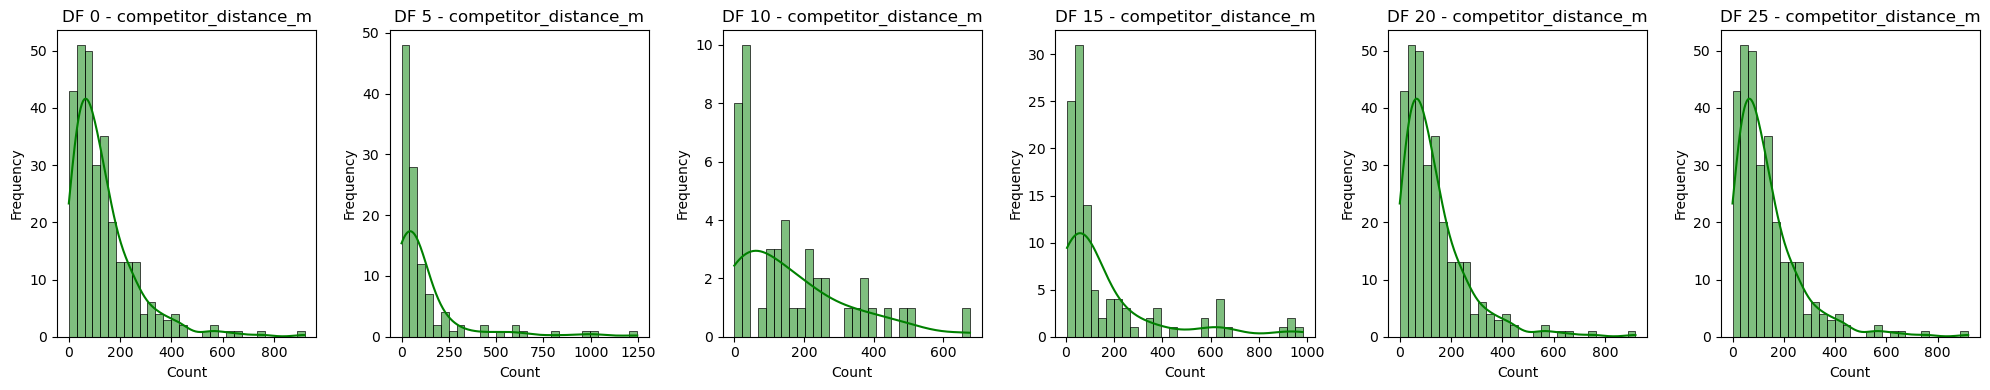

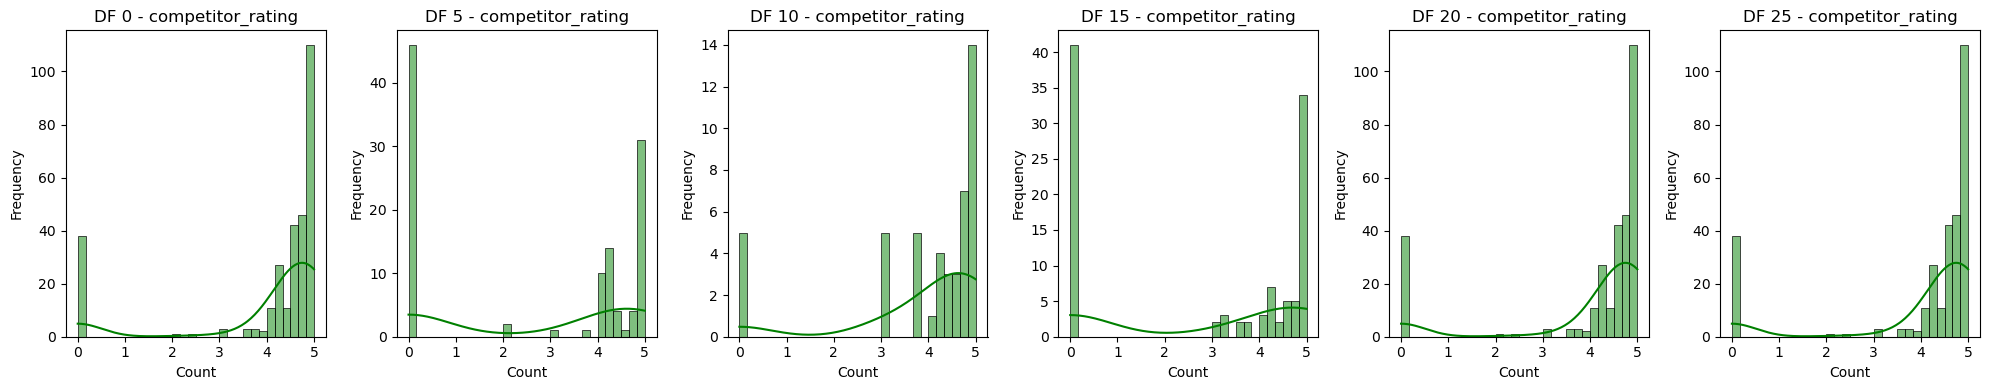

In [26]:
# mengecek distribusi
for column in eda_cols:
    # Mengatur ukuran grid
    num_rows = 1  # Satu baris
    num_cols = len(selected_indices)  # Jumlah dataframe yang dipilih

    # Mengatur ukuran gambar
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))

    # Loop untuk setiap DataFrame yang dipilih
    for i, ax in zip(selected_indices, axes.flat):
        # Mengambil DataFrame dengan indeks yang dipilih
        df = dataframes[i]

        # Plot histogram untuk kolom tertentu dalam satu sub-plot
        sns.histplot(data=df, x=column, bins=30, kde=True, color='green', ax=ax, edgecolor='black')  # Menggunakan sns.histplot() untuk menambahkan kurva

        # Mengatur judul sub-plot
        ax.set_title(f'DF {i} - {column}')
    
        # Menambahkan label sumbu
        ax.set_xlabel('Count')
        ax.set_ylabel('Frequency')

    # Mengatur tata letak agar tidak tumpang tindih
    plt.tight_layout()

    # Menampilkan gambar
    plt.show()

### Cek Multikolinearitas

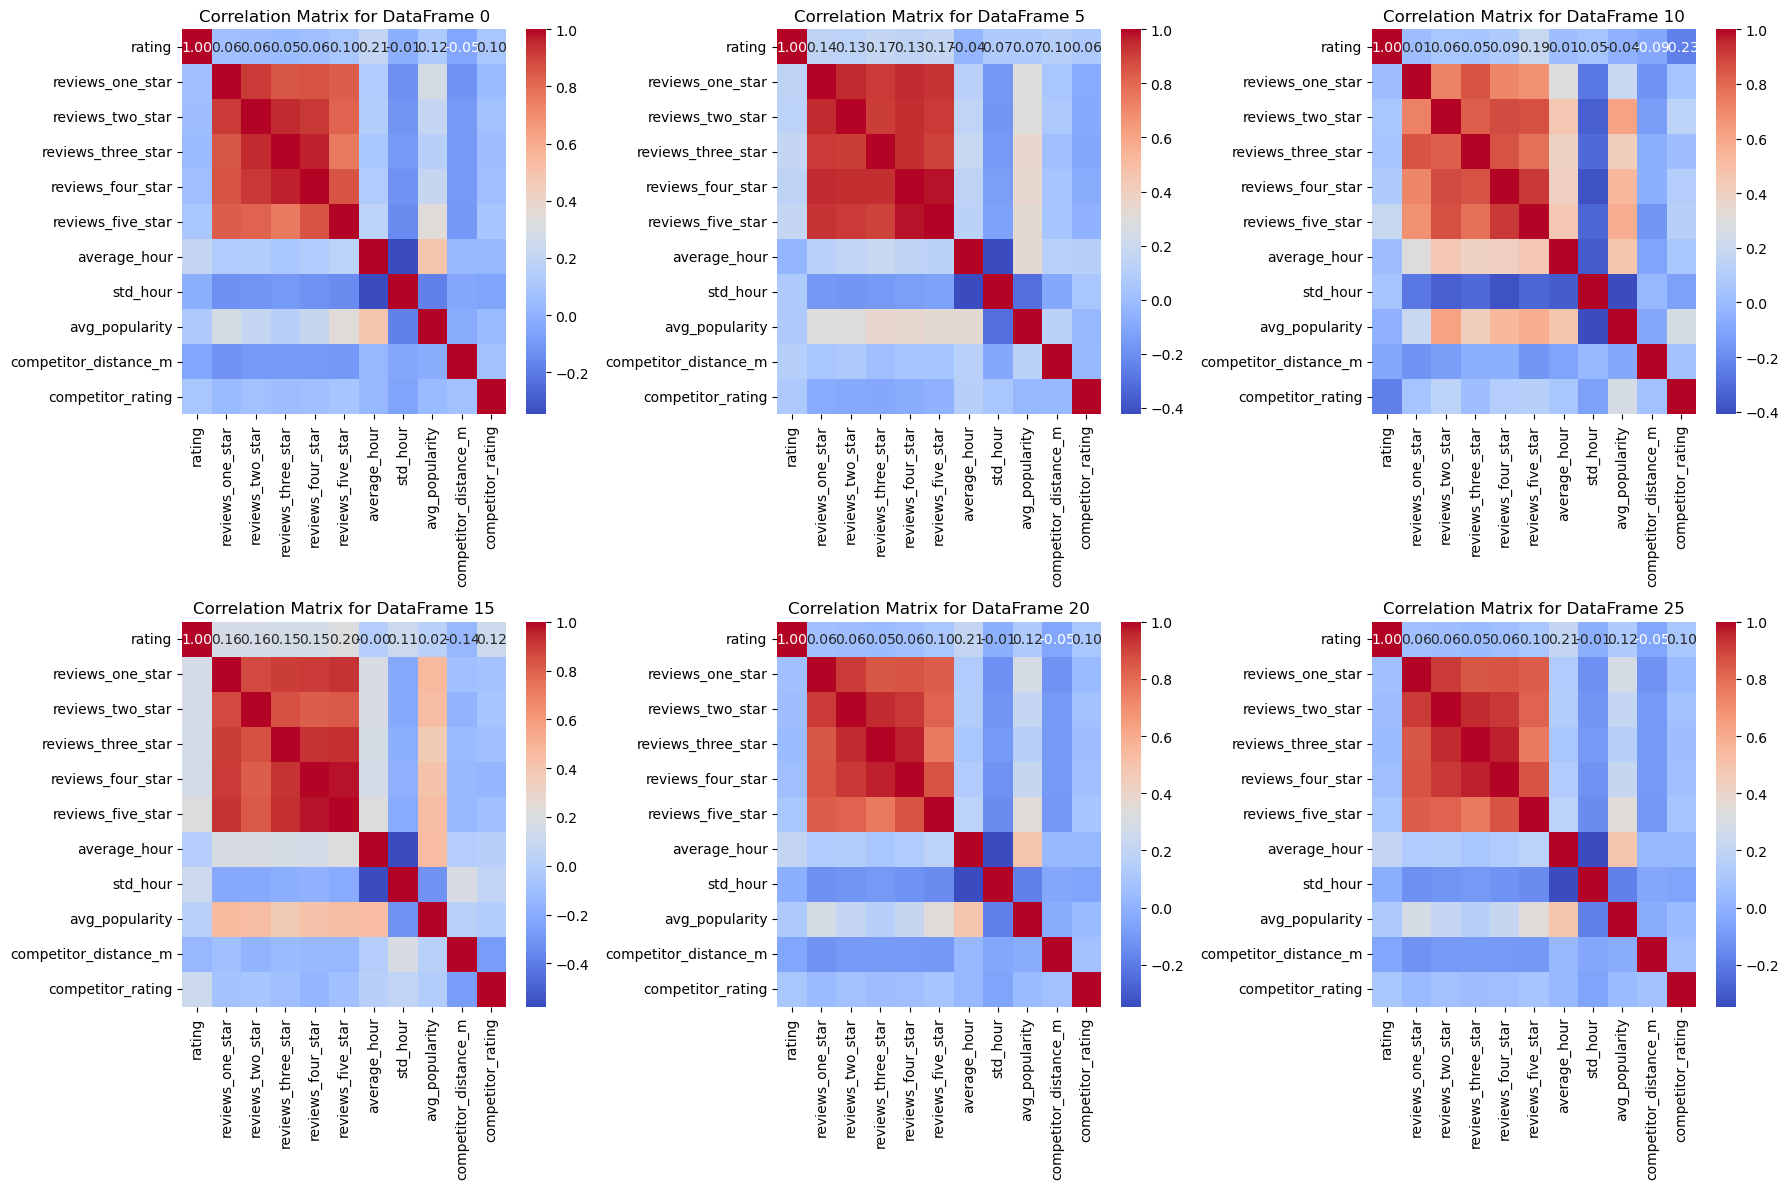

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, ax in enumerate(axes.flat):
    index = i * 5
    selected_columns = eda_cols
    correlation_matrix = dataframes[index][selected_columns].corr()
    
    sns.heatmap(correlation_matrix, ax=ax, annot=True, cmap='coolwarm', fmt=".2f")
    ax.set_title(f"Correlation Matrix for DataFrame {index}")

plt.tight_layout()
plt.show()

### Normalisasi Variabel yang dipakai lalu lakukan PCA

In [28]:
def normalize_and_pca(df, columns, scaler, pca):
    # Menyalin DataFrame
    temp = df.copy(deep=True)
    
    # Mengekstrak kolom yang diinginkan
    matrix_columns = temp[columns].values
    
    # Melakukan fit dan transformasi normalisasi
    normalized_matrix = scaler.fit_transform(matrix_columns)
    
    # Menyimpan hasil transformasi kembali ke DataFrame
    temp[columns] = normalized_matrix
    
    # Melakukan PCA
    principal_components = pca.fit_transform(temp[columns])
    
    # Membuat DataFrame dengan komponen utama
    pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)
    
    # Menambahkan informasi place_id dan name ke DataFrame PCA
    final_df = pd.concat([temp[['place_id', 'name']], pca_df], axis=1)
    
    return final_df

In [29]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Inisialisasi PCA dengan 3 komponen utama
pca = PCA(n_components=3)

# Normalisasi dan PCA semua DataFrame
matrix_df = [normalize_and_pca(df, eda_cols, scaler, pca) for df in dataframes]

# Menampilkan hasil normalisasi dan PCA untuk DataFrame pertama
print("matrix_df 0:")
matrix_df[0].head(3)

matrix_df 0:


,place_id,name,PC1,PC2,PC3
0,ChIJoYMve2jyaS4RZGj2C2pB6gY,"BC DAPOER NGEBOEL,DRIVER RELIGIUS",-0.15,0.02,-0.02
1,ChIJ8cYLG6PzaS4RxnCfoqLuZBw,Aladin Boba Shake & Brew - Condet,-0.13,0.04,-0.35
2,ChIJ2XDrs2fyaS4Rayt7SYelRck,Kedai Tifosi,-0.28,-0.06,0.45


In [30]:
matrix_df[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   place_id  298 non-null    object 
 1   name      298 non-null    object 
 2   PC1       298 non-null    float64
 3   PC2       298 non-null    float64
 4   PC3       298 non-null    float64
dtypes: float64(3), object(2)
memory usage: 11.8+ KB


In [31]:
# define variabel untuk kmeans
list_col = ['PC1', 'PC2', 'PC3']

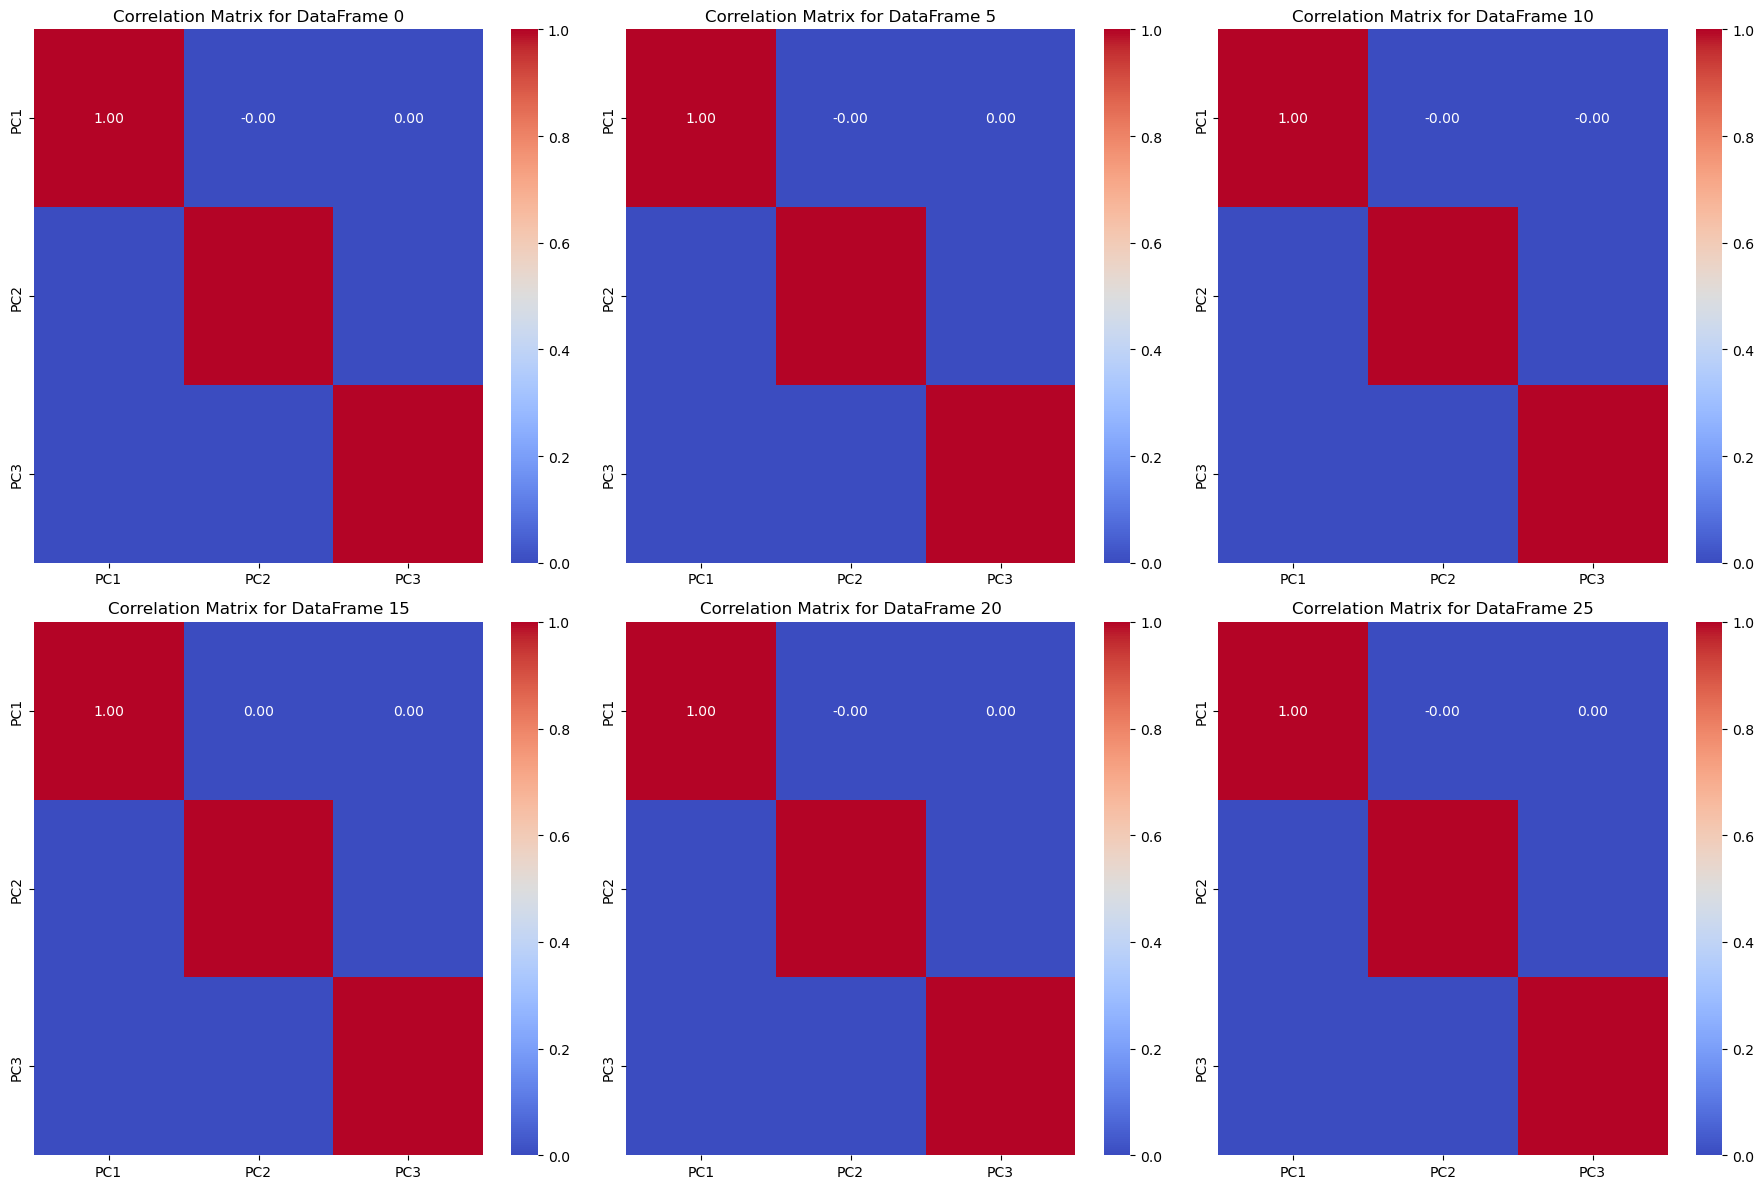

In [32]:
# uji multikolnearitas setelah dilakukan PCA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, ax in enumerate(axes.flat):
    index = i * 5
    selected_columns = list_col
    correlation_matrix = matrix_df[index][selected_columns].corr()
    
    sns.heatmap(correlation_matrix, ax=ax, annot=True, cmap='coolwarm', fmt=".2f")
    ax.set_title(f"Correlation Matrix for DataFrame {index}")

plt.tight_layout()
plt.show()

# Clustering Tensorflow

### Kmeans Algorithm

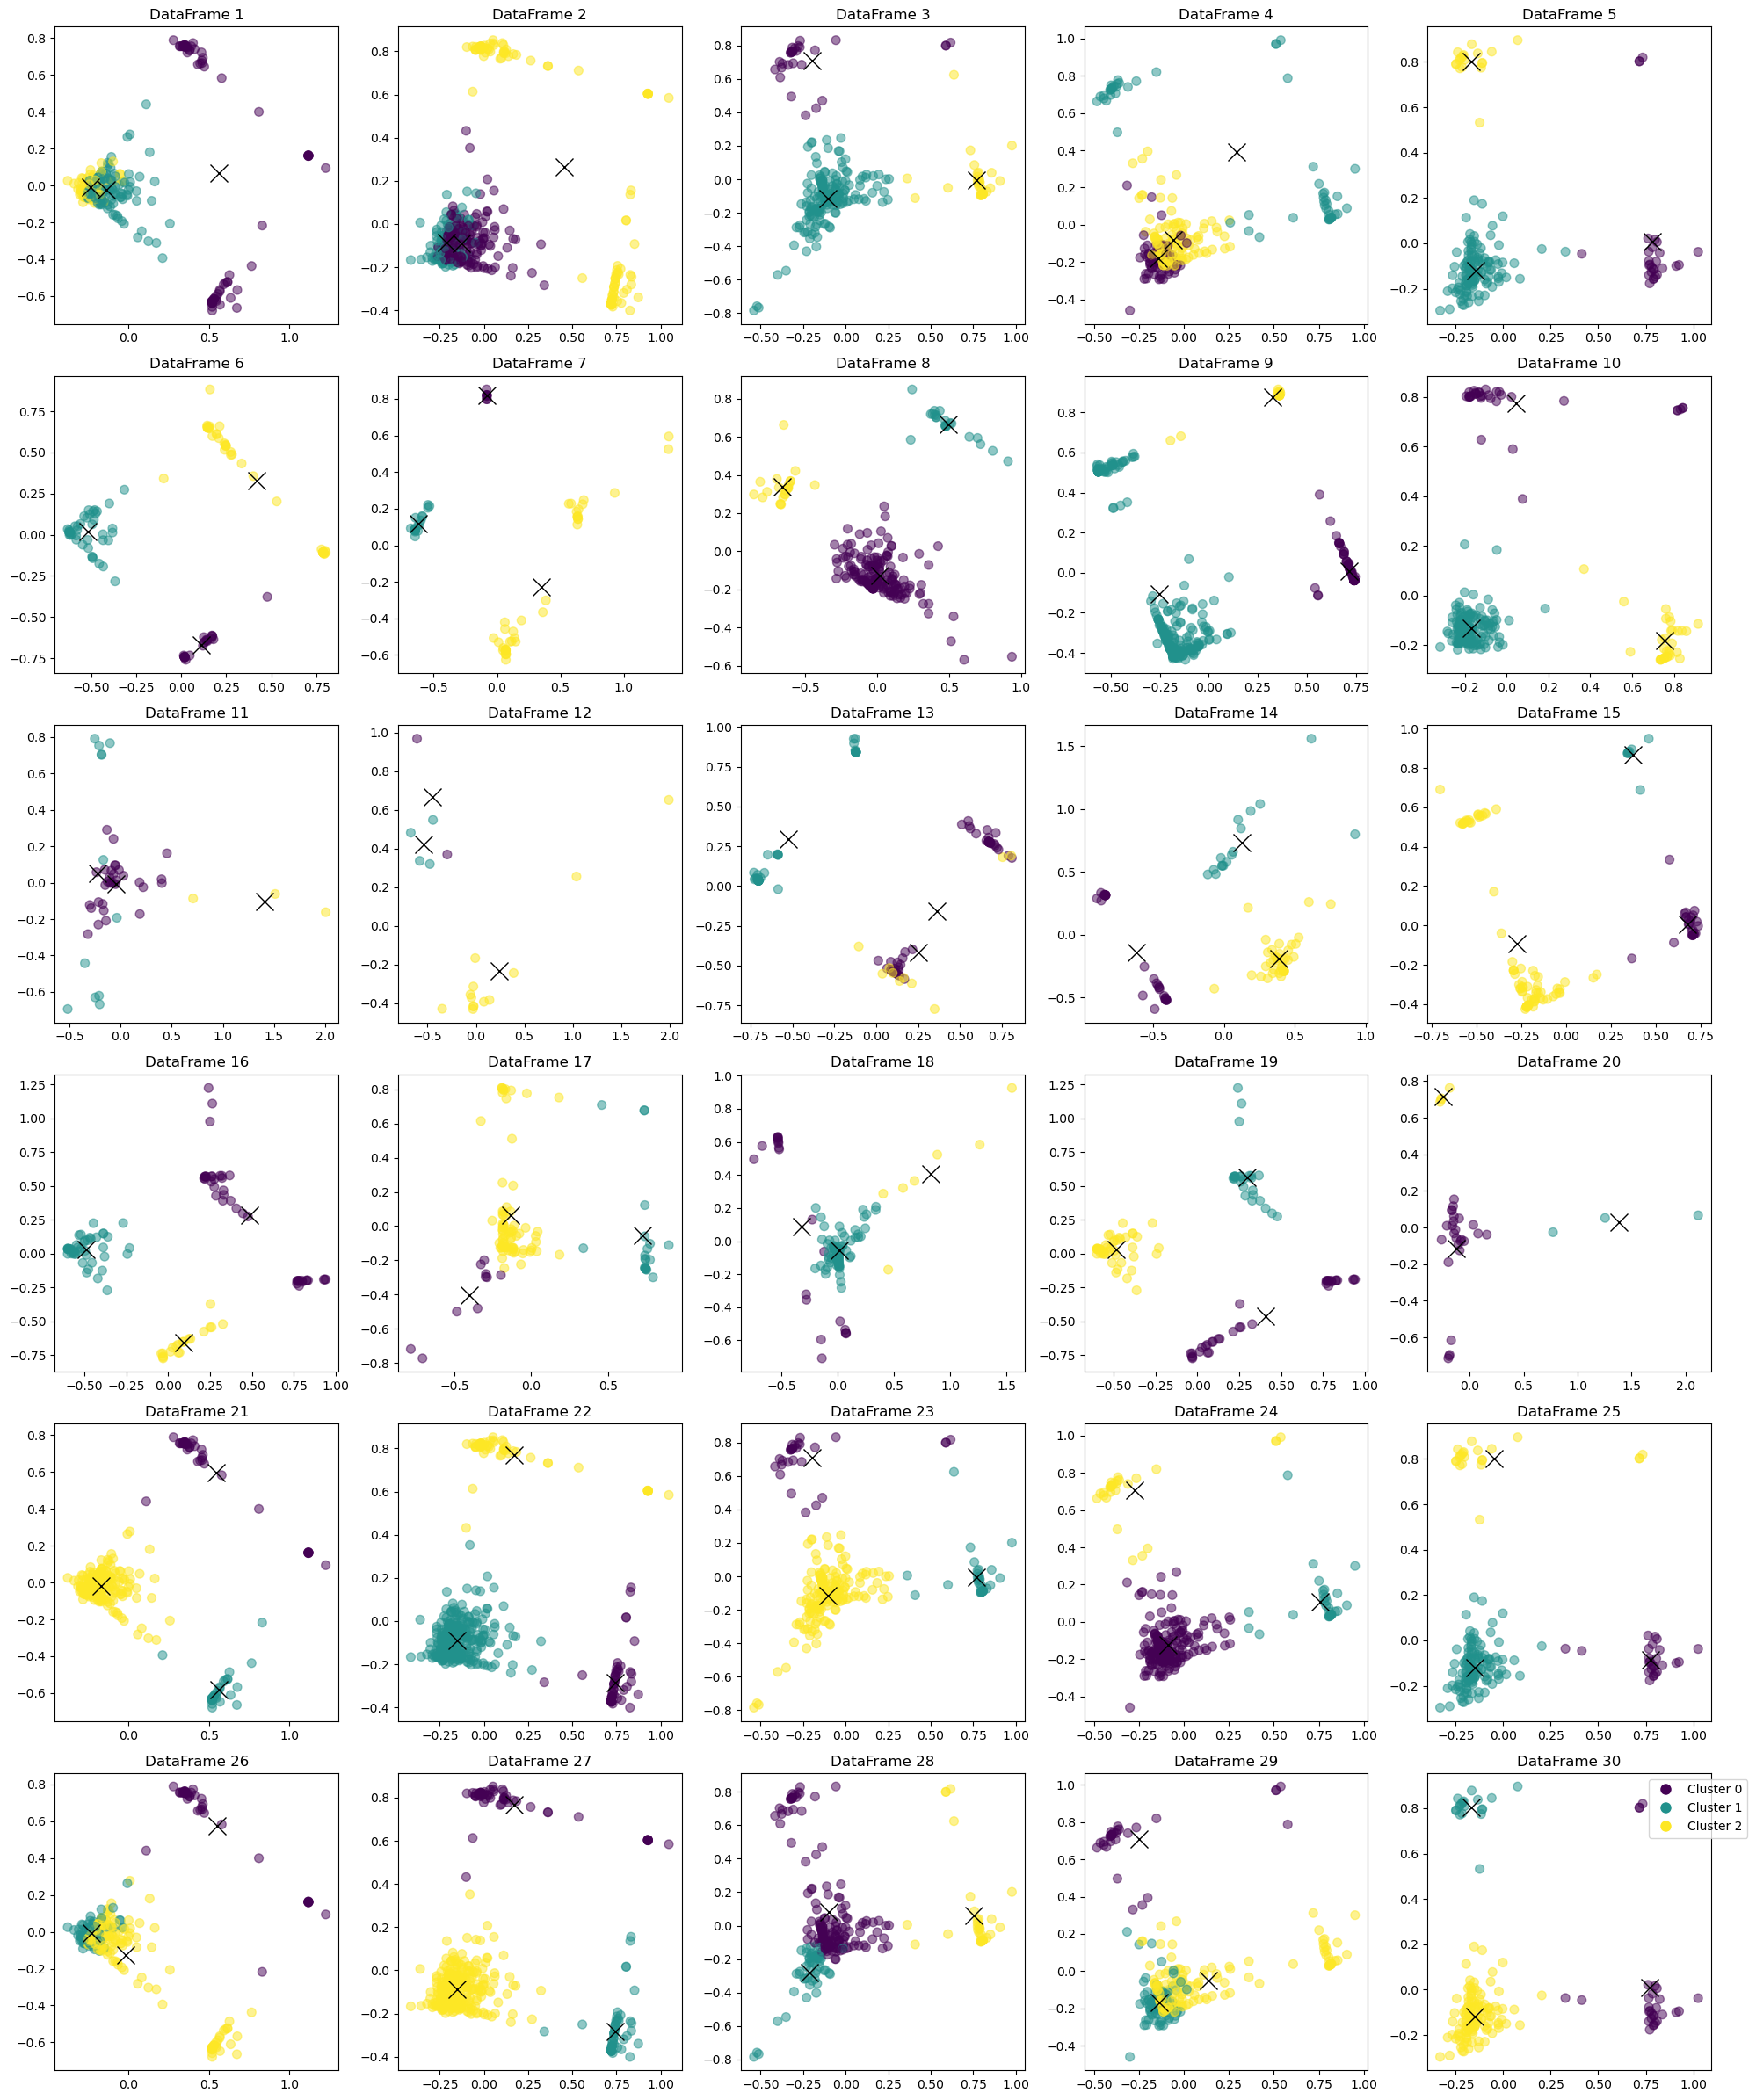

In [33]:
# Fungsi untuk update centroids
def update_centroids(points, assignments, clusters_n):
    means = []
    for c in range(clusters_n):
        cluster_points = tf.gather(points, tf.reshape(tf.where(tf.equal(assignments, c)), [-1]))
        mean = tf.reduce_mean(cluster_points, axis=0)
        means.append(mean)
    return tf.stack(means)

# Parameter jumlah cluster dan jumlah iterasi
clusters_n = 3
iteration_n = 100

# Mengatur ukuran grid
num_rows = 6
num_cols = 5

# Mengatur ukuran gambar
plt.figure(figsize=(20, 24))

# Loop untuk setiap DataFrame
for i in range(len(matrix_df)):
    # Mengambil DataFrame ke-i
    df = matrix_df[i]
    
    # Membuat titik data memakai kolom yang telah di deklarasi pada columns
    points = df[list_col].values
    
    # Membuat centroid awal dengan mengambil secara acak dari points
    centroids = tf.Variable(tf.slice(tf.random.shuffle(points), [0, 0], [clusters_n, -1]))

    # Loop untuk K-means
    for step in range(iteration_n):
        # Memperluas dimensi titik data dan centroid
        points_expanded = tf.expand_dims(points, 0)
        centroids_expanded = tf.expand_dims(centroids, 1)

        # Menghitung jarak dan menentukan penugasan
        distances = tf.reduce_sum(tf.square(points_expanded - centroids_expanded), axis=2)
        assignments = tf.argmin(distances, axis=0)

        # Memperbarui centroid
        new_centroids = update_centroids(points, assignments, clusters_n)
        centroids.assign(new_centroids)

    # Visualisasi data
    points_values = tf.convert_to_tensor(points)
    centroid_values = centroids.numpy()
    assignment_values = assignments.numpy()

    # Mengatur subplot untuk setiap DataFrame
    plt.subplot(num_rows, num_cols, i+1)
    scatter = plt.scatter(points_values[:, 0], points_values[:, 1], c=assignment_values, s=50, alpha=0.5)
    plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
    plt.title(f'DataFrame {i+1}')

    # Menyimpan hasil cluster ke dataframe asli
    dataframes[i]['cluster'] = assignment_values

# Menambahkan legenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10, label=f'Cluster {i}') for i in range(clusters_n)]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

# Menampilkan plot
plt.tight_layout()
plt.show()

In [34]:
dataframes[14].head(8)

,place_id,name,reviews,main_category,rating,reviews_one_star,reviews_two_star,reviews_three_star,reviews_four_star,reviews_five_star,...,longitude,average_hour,std_hour,avg_popularity,top_hour_popularity,top_average_popularity,competitor_place_id,competitor_distance_m,competitor_rating,cluster
0,ChIJYf2CDbWzaS4R0g1Mie2I21w,warung abiel,4,Toko Makanan dan Minuman,5.00,0,0,0,0,4,...,107.04,7.00,2.94,37.71,3.00,45.00,ChIJ928ARj-zaS4RsVNgbr4V4co,441.80,4.30,2
1,ChIJISI8EwmzaS4RQoYuQrzWl4I,Chill House Cafe Cipanas,0,Kafe dan Kedai Kopi,0.00,0,0,0,0,0,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJgUSCPEWzaS4RaW4AK0hwiB4,129.28,4.90,0
2,ChIJzVbeMxOzaS4RD9_WoIkaWpI,Family Food,1,Lainnya,5.00,0,0,0,0,1,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJf_jnAQqzaS4RrAj66rxvFzA,348.31,4.10,2
3,ChIJt4U3tgezaS4RBEEZmJvXKUY,Scrumptious food,33,Restoran,4.60,2,0,1,2,28,...,107.03,17.00,0.82,54.44,17.00,60.83,ChIJZwkxHlqzaS4RJMfB8Od2Zik,256.49,0.00,2
4,ChIJmwD1W6uzaS4RiZFQDp2wFRg,Kedai bubuk minuman cipanas cianjur,0,Kafe dan Kedai Kopi,0.00,0,0,0,0,0,...,107.01,16.33,1.96,51.93,16.51,55.30,ChIJOWy4ZHqzaS4RWpR72BjpBgs,243.12,0.00,1
5,ChIJgUSCPEWzaS4RaW4AK0hwiB4,Feys Katsu,19,Kafe dan Kedai Kopi,4.90,0,0,0,2,17,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJISI8EwmzaS4RQoYuQrzWl4I,129.28,0.00,2
6,ChIJPfWPbAezaS4Rj-NuKtn6iuM,Sarupaning Drink & Snack,1,Restoran,5.00,0,0,0,0,1,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJxUykRF-zaS4RrhFMo4r2Ej0,355.89,4.60,2
7,ChIJqQy0pBmzaS4R5b9e0Mk0sLo,Geraiss Food,2,Restoran,5.00,0,0,0,0,2,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJSxDJw6-zaS4RD7m_azvnNOM,82.74,5.00,2


In [35]:
dataframes[14].shape

(110, 21)

In [36]:
dataframes[14].loc[dataframes[14]['cluster'] == 2]

,place_id,name,reviews,main_category,rating,reviews_one_star,reviews_two_star,reviews_three_star,reviews_four_star,reviews_five_star,...,longitude,average_hour,std_hour,avg_popularity,top_hour_popularity,top_average_popularity,competitor_place_id,competitor_distance_m,competitor_rating,cluster
0,ChIJYf2CDbWzaS4R0g1Mie2I21w,warung abiel,4,Toko Makanan dan Minuman,5.00,0,0,0,0,4,...,107.04,7.00,2.94,37.71,3.00,45.00,ChIJ928ARj-zaS4RsVNgbr4V4co,441.80,4.30,2
2,ChIJzVbeMxOzaS4RD9_WoIkaWpI,Family Food,1,Lainnya,5.00,0,0,0,0,1,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJf_jnAQqzaS4RrAj66rxvFzA,348.31,4.10,2
3,ChIJt4U3tgezaS4RBEEZmJvXKUY,Scrumptious food,33,Restoran,4.60,2,0,1,2,28,...,107.03,17.00,0.82,54.44,17.00,60.83,ChIJZwkxHlqzaS4RJMfB8Od2Zik,256.49,0.00,2
5,ChIJgUSCPEWzaS4RaW4AK0hwiB4,Feys Katsu,19,Kafe dan Kedai Kopi,4.90,0,0,0,2,17,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJISI8EwmzaS4RQoYuQrzWl4I,129.28,0.00,2
6,ChIJPfWPbAezaS4Rj-NuKtn6iuM,Sarupaning Drink & Snack,1,Restoran,5.00,0,0,0,0,1,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJxUykRF-zaS4RrhFMo4r2Ej0,355.89,4.60,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ChIJxdlV_razaS4RY4kLttp5vTc,Green Bee Food & Beverage,17,Restoran,4.70,0,0,1,3,13,...,107.05,17.00,0.82,61.89,17.00,66.33,ChIJ7zN-HMizaS4RvRgiIX7s1cw,38.04,0.00,2
104,ChIJcZrCeh6zaS4RXiQmdRZ8Ozg,Family Food,3,Kafe dan Kedai Kopi,4.70,0,0,0,1,2,...,107.04,10.00,0.82,35.52,10.00,40.14,ChIJ0UIGWZazaS4RpEIi-5NwWZY,27.11,4.60,2
106,ChIJ0UIGWZazaS4RpEIi-5NwWZY,Binangkit Food,5,Kafe dan Kedai Kopi,4.60,0,0,0,2,3,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJcZrCeh6zaS4RXiQmdRZ8Ozg,27.11,4.70,2
108,ChIJk8K4LOizaS4RWT4HtFEHA5g,Home Kitchen Food,2,Kafe dan Kedai Kopi,4.00,0,0,1,0,1,...,107.04,16.33,1.96,51.93,16.51,55.30,ChIJOyRu6YKzaS4RtvuNulqfQY0,70.78,0.00,2


## Statistika Deskriptif antar Cluster

In [37]:
# Fungsi untuk menghitung modus (nilai yang paling sering muncul)
def mode(series):
        return series.mode().iloc[0]

# Fungsi untuk menghitung modus dari main_category berdasarkan top 50 top_average_popularity
def popular_category_mode(df):
    if len(df) >= 10:
        top_10 = df.nlargest(10, 'top_average_popularity')
    else:
        top_10 = df
    if not top_10['main_category'].empty:
        return top_10['main_category'].mode().iloc[0]
    else:
        return None

# Fungsi untuk menghitung statistik deskriptif
def calculate_descriptive_stats(df):
    # Menambahkan kolom baru untuk menghitung place_id dengan zero review
    df['zero_review'] = (df['reviews'] == 0).astype(int)
    
    # Menambahkan kolom baru untuk jumlah rating 1-3 dan 4-5
    df['rating_1_3'] = df['reviews_one_star'] + df['reviews_two_star'] + df['reviews_three_star']
    df['rating_4_5'] = df['reviews_four_star'] + df['reviews_five_star']
    
    # Menghitung popular_category berdasarkan top 50 top_average_popularity
    popular_categories = df.groupby('cluster').apply(popular_category_mode).reset_index(level=0, drop=True)
    
    # Menghitung statistik deskriptif
    descriptive_stats = df.groupby('cluster').agg({
        'place_id': 'count',
        'main_category': [mode],
        'rating': ['min', 'max', 'mean'],
        'zero_review': 'sum',  
        'reviews_one_star': ['min', 'max', 'mean'],
        'reviews_two_star': ['min', 'max', 'mean'],
        'reviews_three_star': ['min', 'max', 'mean'],
        'reviews_four_star': ['min', 'max', 'mean'],
        'reviews_five_star': ['min', 'max', 'mean'],
        'rating_1_3': ['min', 'max', 'mean'],  
        'rating_4_5': ['min', 'max', 'mean'],  
        'competitor_distance_m': ['min', 'max', 'mean'],
        'top_average_popularity': ['min', 'max', 'mean']
    }).reset_index()
    
    # Menambahkan popular_category ke descriptive_stats
    descriptive_stats['popular_category'] = popular_categories.values
    
    return descriptive_stats

# Membuat 30 dataframes baru
stats_cluster_df = []
for i in range(30):
    descriptive_stats = calculate_descriptive_stats(dataframes[i])
    stats_cluster_df.append(descriptive_stats)

In [38]:
stats_cluster_df[22]

cluster place_id main_category rating           zero_review  \
             count          mode    min  max mean         sum   
0       0       29      Restoran   0.00 5.00 4.31           3   
1       1       32      Restoran   0.00 2.20 0.17          29   
2       2      178      Restoran   2.70 5.00 4.56           0   

  reviews_one_star           ... rating_4_5               \
               min max mean  ...        min   max   mean   
0                0   9 0.59  ...          0   191  20.41   
1                0   5 0.28  ...          0     2   0.09   
2                0  90 6.84  ...          1  4118 170.52   

  competitor_distance_m                top_average_popularity              \
                    min     max   mean                    min   max  mean   
0                 30.89  530.83 154.27                  31.29 82.86 57.01   
1                 30.89 1093.33 187.92                  19.86 55.30 52.82   
2                  0.00 1002.49 118.76                  28.29 92.86 61.68   

      popular_category  
                        
0  Kafe dan Kedai Kopi  
1  Kafe dan Kedai Kopi  
2             Restoran  

[3 rows x 35 columns]

In [39]:
# List kolom yang ingin Anda sertakan dalam DataFrame baru
selected_columns = [
    ('cluster',''),
    ('place_id', 'count'),
    ('main_category', 'mode'),  
    ('rating', 'mean'),         
    ('main_category', 'mode'),   
    ('rating_1_3', 'mean'),      
    ('rating_4_5', 'mean'),      
    ('popular_category', '')    
]


# List untuk menyimpan DataFrame baru
selected_dfs = []

# Loop melalui setiap DataFrame dalam stats_cluster_df
for df in stats_cluster_df:
    # Buat DataFrame baru hanya dengan variabel yang dipilih
    new_df = df[[col for col in df.columns if col in selected_columns]]
    # Tambahkan DataFrame baru ke dalam list
    selected_dfs.append(new_df)

In [76]:
selected_dfs[0]

,cluster,place_id,main_category,rating,rating_1_3,rating_4_5,popular_category
,,count,mode,mean,mean,mean,
0,0,69,Kafe dan Kedai Kopi,2.00,1.43,7.65,Kafe dan Kedai Kopi
1,1,156,Kafe dan Kedai Kopi,4.67,2.34,18.40,Kafe dan Kedai Kopi
2,2,73,Kafe dan Kedai Kopi,4.63,43.45,323.71,Kafe dan Kedai Kopi


### Cluster Count

In [86]:
def assign_cluster(count_series):
    # Mengurutkan nilai count_series secara menurun
    sorted_counts = count_series.sort_values(ascending=False)
    
    # Mendapatkan jumlah elemen dalam count_series
    num_elements = len(sorted_counts)
    
    # Membagi nilai count_series menjadi tiga cluster
    cluster_size = num_elements // 3
    
    # Menginisialisasi daftar untuk menyimpan nama cluster
    clusters = []
    
    # Menyimpan nama cluster A
    clusters.extend(['Cluster A'] * cluster_size)
    
    # Menyimpan nama cluster B
    clusters.extend(['Cluster B'] * cluster_size)
    
    # Menyimpan nama cluster C, memastikan jumlah elemen sama dengan num_elements
    clusters.extend(['Cluster C'] * (num_elements - (2 * cluster_size)))
    
    # Mengonversi daftar cluster menjadi Series dengan index yang sama dengan count_series
    cluster_series = pd.Series(clusters, index=sorted_counts.index)
    
    return cluster_series


In [88]:
assign_cluster(selected_dfs[0]['place_id'].value_counts())

count
69       Cluster A
73       Cluster B
156      Cluster C
dtype: object